# TODO: Add a cool Title here

## 1. Briefing

|            |          |                     |
|------------|----------|---------------------|
| Subject    |          | Machine Learning    |
| Supervisor |          | Prof. Aswin Kannan  |
|            |          |                     |
| Team Name  |          | MT2025724_MT2025732 |
| Member 1   | Name:    | Shreg               |
|            | Roll No: | MT2025724           |
| Member 2   | Name:    | Anisha              |
|            | Roll No: | MT2025732           |
|            |          |                     |

TODO: Add some numericals like the number of models compared, number of data processing techniques applied...

### Keywords

## 2. Summary

* 4–8 bullet points summarizing highest-level conclusions (best model(s), tradeoffs, recommended next steps).
* Short comparative table of winners by criteria (accuracy, latency, model size, fairness, etc.)

## 3. Introduction

* Problem statement and motivation
* Objectives of the comparative study (what questions you will answer)
* Scope (datasets, model families, compute constraints)
* Contributions (what unique analyses you provide — e.g., timing, memory profiling, calibration, fairness tests)


In [2]:
# Notification system for slow steps - I multitask, so a ping really helps when long steps are completed to bring back my attention.
# Remember, _attention is all you need_! xD
import chime

# The universe loves chaos, but reproducibility doesn’t.
# Imported mainly to set seed for other libraries which depend on it.
import random

# Because time waits for no one, but at least we can measure how fast it runs away.
import time

# Metadata serialization
# Question for you, what's the difference between JS and JSON?
import json

# Big fan of java's streams. A programmer who cant make an easy task difficult, is not a programmer!
import functools, itertools

# Like... Who has the time for those anyway
import warnings

# The Swiss army knife of data
import pandas as pd

# Where math meets meth
import numpy as np

# Where math doesnt meth
import scipy as sp

# Bag of all ML models
import sklearn as skl
import xgboost as xgb
import shap

# An artist bringing data to life
import matplotlib.pyplot as plt

# The artist's wardrobe
import matplotlib as mpl

# Pyplot's quirkier cousin
import seaborn as sns

# Never going to use it, but make me feel prepared
from pprint import pprint

# If I can’t see it moving, it’s not working.
from tqdm import tqdm

import IPython.display as d

In [3]:
# TODO Add PIP install statements for unusual libraries like chime and xgboost

### Notification System Setup

In [4]:
chime.theme("material")
chime.info()

### PyPlot Setup

In [30]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
wid_fig = (8, 3)


# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(suptitle: str = None, constrained=False):
    compose(plt.suptitle, suptitle, font_suptitle)
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.show()


chime.info()

|### Randomizer Setup

In [6]:
default_seed = 1114  # 1114 stands for Minecraftian14, which is me, ofc


def reset_seed(seed=default_seed):
    random.seed(seed)
    np.random.seed(seed)


chime.info()

### Presentor Setup

In [7]:
displayMD = lambda x: display(d.Markdown(x))
kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())
header = lambda n, field: "%s %s" % ("#" * n, field)
quote = lambda field: "\n\n> %s" % field.replace("\n", "\n> ")
list_out = lambda title, list: header(4, "%s\n\n* %s" % (title, "\n* ".join(list)))

# displayMD(header(3, kv("Hmm", "10")))
# displayMD(header(4, kv("Hmm", "10")))
# displayMD(quote(kv("Hmm", "10")))
# displayMD(list_out("Fruits", ["apple", "banana", "orange"]))

### Other Helpers

In [8]:
def flatten(obj):
    if hasattr(obj, '__iter__') and not isinstance(obj, str):
        if hasattr(obj[0], '__iter__') and not isinstance(obj[0], str):
            return list(itertools.chain.from_iterable(obj))
        return obj
    return [obj]

### Data Helpers

In [9]:
def pop_drop_column(data, columns=None):
    if isinstance(data, pd.DataFrame): data.drop(columns=columns, inplace=True)
    return columns, None


def pop_log_transform(data, base=np.e):
    return base, np.log(data) / np.log(base)


def pop_root_transform(data, exp=0.5):
    return exp, np.power(data, exp)


def pop_box_cox_transform(data):
    data, lam = sp.stats.boxcox(data)
    return lam, data


def pop_one_hot_encode(data, name=None):
    if isinstance(data, pd.Series) and name is None: name = data.name
    return np.unique(data), pd.get_dummies(data, name)


def pop_soft_ohe(data, split_points):
    produce = []
    produce.append((data < split_points[1]))
    for s, e in zip(split_points[0:-2], split_points[2:]):
        produce.append(data * (data > s) * (data < e))
    produce.append(data * (data > split_points[-2]))
    return split_points, produce


def pop_binarize(data):
    assert len(np.unique_counts(data)) == 2
    pri_val, data = data[0], data == data[0]
    if isinstance(data, pd.Series): data.name = "is_%s_%s" % (data.name, pri_val)
    return pri_val, data


def pop_standardize(data):
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    return (mean, std), (data - mean) / std


def pop_minmax(data):
    min, max = np.min(data, axis=0), np.max(data, axis=0)
    return (min, max), (data - min) / (max - min)


def pop_ordinal_encode(data):
    uniques, encoded = np.unique(data, return_inverse=True)
    if isinstance(data, pd.Series): encoded = pd.Series(encoded, index=data.index, name=data.name)
    return uniques, encoded


def compose_pop(*pop_operations):
    pop_operations = flatten(pop_operations)

    def pop_composed(data):
        arguments = []
        for pop_operation in pop_operations:
            args, data = pop_operation(data)
            if data is None: continue
            arguments.append([pop_operation.__name__, args])
        return arguments, data

    return pop_composed


def pop_round(data, decimals=0):
    return decimals, np.round(data, decimals=decimals)


def pop_derived_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data["BMI"] = data["Weight"] / (data["Height"] ** 2)
    data["Water_Intake_per_Meal"] = data["CH2O"] / (data["NCP"] + 1e-6)
    data["Activity_to_Tech_Ratio"] = data["FAF"] / (data["TUE"] + 0.1)
    data["Healthy_Lifestyle_Score"] = (data["FCVC"] * 0.3 + data["FAF"] * 0.3
                                       + data["CH2O"] * 0.4 - data["FAVC"].map({"yes": 1, "no": 0}))
    data["Has_FamilyRisk_and_FAVC"] = np.where(
        (data["FHWO"] == "yes") & (data["FAVC"] == "yes"), 1, 0)
    data["Calorie_Monitoring_Interaction"] = (data["SCC"].map({"yes": 1, "no": 0})
                                              * data["FAVC"].map({"yes": 1, "no": 0}))
    return None, data


def prepare_pop(pop_operation, *args):
    def pop_prepared(data):
        return pop_operation(data, *args)

    return pop_prepared


def to_ser_op(ds: pd.DataFrame, col, pop_operation, keep_col=False, out_ds=None):
    data = ds[col]
    if not keep_col: ds.drop(columns=flatten(col), inplace=True)
    arg, data = compose_pop(pop_operation)(data)
    if out_ds is not None: ds = out_ds
    if data is None: return arg, ds
    if isinstance(data, list):
        for idx, sample in enumerate(data):
            ds["%s_%d" % (col, idx)] = sample
    elif isinstance(data, pd.DataFrame):
        for column in data.columns:
            ds[column] = data[column]
    else:
        ds[col] = data
    return arg, ds


def apply_pipeline(ds: pd.DataFrame, pipeline, to_numpy=True):
    compulsory, permutable = pipeline[0], pipeline[1]
    ds = ds.copy()
    arguments = []
    for pop_operation, columns in compulsory:
        for column in columns:
            if (not isinstance(column, str)) or (column in ds.columns):
                arg, _ = to_ser_op(ds, column, pop_operation, keep_col=False)
                arguments.append(arg)
    if len(permutable) == 0:
        yield arguments, ds.to_numpy() if to_numpy else ds
    for permutation in permutable:
        ds_ans = ds.copy()
        perm_arguments = arguments.copy()
        for pop_operation, columns in permutation:
            for column in columns:
                if (not isinstance(column, str)) or (column in ds_ans.columns):
                    arg, _ = to_ser_op(ds_ans, column, pop_operation, keep_col=False)
                    perm_arguments.append(arg)
        yield perm_arguments, ds_ans.to_numpy() if to_numpy else ds

## ?. Data Loading

In [10]:
for option in ['../../data/ait-511-course-project-1-obesity-risk/train.csv', 'train.csv', 'data/train.csv']:
    try:
        ds_source = pd.read_csv(option)
        print('Training data found at', option)
        ds_test = pd.read_csv(option.replace('train.csv', 'test.csv'))
        break
    except:
        print('No training data found at', option)

try:
    ds_source.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)
    ds_test.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)
except NameError:
    displayMD(header(1, 'No data found anywhere'))

chime.info()

Training data found at ../../data/ait-511-course-project-1-obesity-risk/train.csv


In [11]:
n_samples_all, n_columns = ds_source.shape
n_features_raw = n_columns - 2  # id and targets

target_labels = ds_source['WeightCategory'].unique()
n_targets = len(target_labels)

displayMD(header(4, kv('Number of total samples', n_samples_all)))
displayMD(header(4, kv('Number of total columns', n_columns)))
displayMD('---')
displayMD(header(4, kv('Number of features', n_features_raw)))
displayMD(header(4, kv('Number of classes', n_targets)))

#### **Number of total samples:** `15533`

#### **Number of total columns:** `18`

---

#### **Number of features:** `16`

#### **Number of classes:** `7`

In [12]:
column_full_names = {
    'id': 'Entity Identifier', 'Gender': 'Gender', 'Age': 'Age', 'Height': 'Height', 'Weight': 'Weight',
    'FHWO': 'Family History With Overweight', 'FAVC': 'High Caloric Food Consumption Freq.',
    'FCVC': 'Vegetables Consumption Freq.', 'NCP': 'Main Meals Count', 'CAEC': 'Consumption of Food Between Meals',
    'SMOKE': 'Smoke', 'CH2O': 'Consumption of Water Daily', 'CALC': 'Consumption of alcohol',
    'SCC': 'Calories Consumption Monitoring', 'FAF': 'Physical Activity Freq.', 'TUE': 'Time using Technology Devices',
    'MTRANS': 'Modes of Transportation Used', 'WeightCategory': 'Weight Category', }

In [13]:
info = pd.io.formats.info.DataFrameInfo(
    data=ds_source,
    memory_usage=None,
)
ds_info = pd.DataFrame(zip(info.ids, info.ids.map(column_full_names), info.non_null_counts, info.dtypes),
                       columns=['Column Name', 'Description', 'Non-Null Count', 'Data Type'])

In [14]:
displayMD(header(3, kv('Memory Usage', info.memory_usage_string)))
display(ds_info)

### **Memory Usage:** `2.1+ MB`

,Column Name,Description,Non-Null Count,Data Type
0,id,Entity Identifier,15533,int64
1,Gender,Gender,15533,object
2,Age,Age,15533,float64
3,Height,Height,15533,float64
4,Weight,Weight,15533,float64
5,FHWO,Family History With Overweight,15533,object
6,FAVC,High Caloric Food Consumption Freq.,15533,object
7,FCVC,Vegetables Consumption Freq.,15533,float64
8,NCP,Main Meals Count,15533,float64
9,CAEC,Consumption of Food Between Meals,15533,object


In [15]:
gb_info_by_dtype = ds_info.groupby('Data Type')['Column Name'].apply(list)
display(pd.DataFrame({
    t: items + [''] * (gb_info_by_dtype.map(len).max() - len(items))
    for t, items in gb_info_by_dtype.items()
}))

,int64,float64,object
0,id,Age,Gender
1,,Height,FHWO
2,,Weight,FAVC
3,,FCVC,CAEC
4,,NCP,SMOKE
5,,CH2O,SCC
6,,FAF,CALC
7,,TUE,MTRANS
8,,,WeightCategory


In [16]:
display(ds_source.head(5))

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [17]:
display(ds_source.describe(include='all'))

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
count,15533.000000,15533,15533.000000,15533.000000,15533.000000,15533,15533,15533.000000,15533.000000,15533,15533,15533.000000,15533,15533.000000,15533.000000,15533,15533,15533
unique,NaN,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,5,7
top,NaN,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,NaN,7783,NaN,NaN,NaN,12696,14184,NaN,NaN,13126,15356,NaN,15019,NaN,NaN,11285,12470,2983
mean,7766.000000,NaN,23.816308,1.699918,87.785225,NaN,NaN,2.442917,2.760425,NaN,NaN,2.027626,NaN,0.976968,0.613813,NaN,NaN,NaN
std,4484.135201,NaN,5.663167,0.087670,26.369144,NaN,NaN,0.530895,0.706463,NaN,NaN,0.607733,NaN,0.836841,0.602223,NaN,NaN,NaN
min,0.000000,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,3883.000000,NaN,20.000000,1.630927,66.000000,NaN,NaN,2.000000,3.000000,NaN,NaN,1.796257,NaN,0.007050,0.000000,NaN,NaN,NaN
50%,7766.000000,NaN,22.771612,1.700000,84.000000,NaN,NaN,2.342220,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.566353,NaN,NaN,NaN
75%,11649.000000,NaN,26.000000,1.762921,111.600553,NaN,NaN,3.000000,3.000000,NaN,NaN,2.531456,NaN,1.582675,1.000000,NaN,NaN,NaN


In [18]:
redundant_columns = ['id']
target_columns = ['WeightCategory']

gaussian_features = ['Age', 'Height', 'Weight']
partial_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC']
nary_features = ['CAEC', 'CALC', 'MTRANS']

numerical_features = gaussian_features + partial_features
categorical_features = binary_features + nary_features
all_features = numerical_features + categorical_features

numerical_derived_features = ["BMI", "Water_Intake_per_Meal", "Activity_to_Tech_Ratio", "Healthy_Lifestyle_Score"]
binary_derived_features = ["Has_FamilyRisk_and_FAVC", "Calorie_Monitoring_Interaction"]
derived_features = numerical_derived_features + binary_derived_features

label_encoder = {label: index for index, label in enumerate(target_labels)}
label_decoder = {index: label for index, label in enumerate(target_labels)}

## ?. Data Presentation

#### Missing Value Detection

In [19]:
display(ds_source.isnull().sum().to_frame(name='Missing_Count'))

,Missing_Count
id,0
Gender,0
Age,0
Height,0
Weight,0
FHWO,0
FAVC,0
FCVC,0
NCP,0
CAEC,0


**Observation**: There is not a single missing value in any of the columns

**Inference**: The dataset is pretty good in this department! We do not have to perform any sorts of missing value handling procedures like removal, imputation or flagging.

#### Outlier Detection

In [20]:
def count_outliers(ds: pd.DataFrame, column: str):
    quan25 = ds[column].quantile(0.25)
    quan75 = ds[column].quantile(0.75)
    iqr = quan75 - quan25
    lower_limit = quan25 - 1.5 * iqr
    upper_limit = quan75 + 1.5 * iqr
    return len(ds[(ds[column] > upper_limit) | (ds[column] < lower_limit)])


_ds_num = ds_source[numerical_features]
display(pd.DataFrame(zip(_ds_num.columns, [count_outliers(_ds_num, col) for col in _ds_num.columns]),
                     columns=['', 'Outliers_Count']))

,,Outliers_Count
0,Age,792
1,Height,4
2,Weight,0
3,FCVC,0
4,NCP,4548
5,CH2O,0
6,FAF,0
7,TUE,0


**Observation**: TODO

**Inference**: TODO

#### Feature Distribution

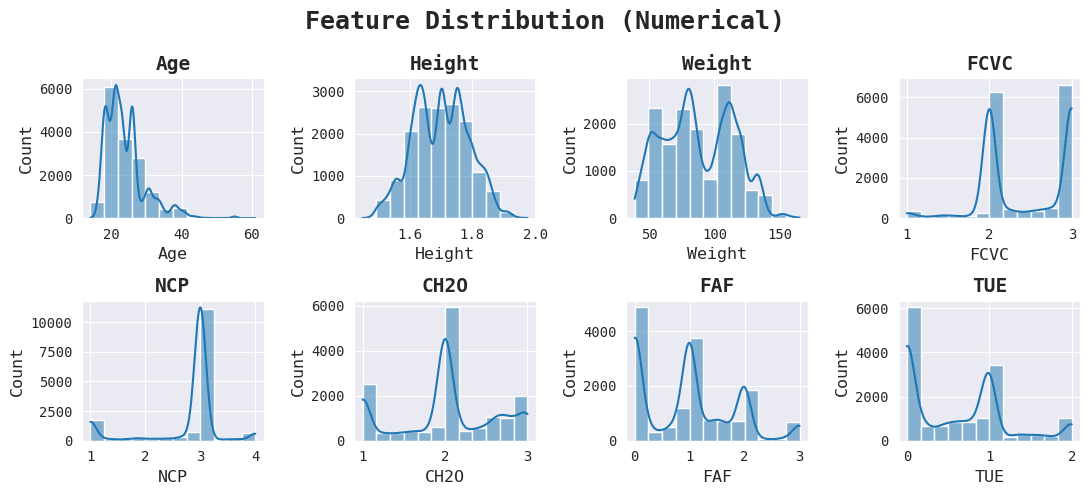

In [21]:
fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), numerical_features):
    sns.histplot(ds_source[col], kde=True, bins=12, ax=ax)
    annotate_plot(ax, col)
conclude_plot("Feature Distribution (Numerical)")

**Observation**:
* Age dataset is clearly far too skewed towards the left
* All features other than Age, Height and Weight do not follow a conventional distribution. <br/> Rather, they have a characteristic misture of discrete sampling and a gaussian likeness.
* TODO

**Inference**: TODO

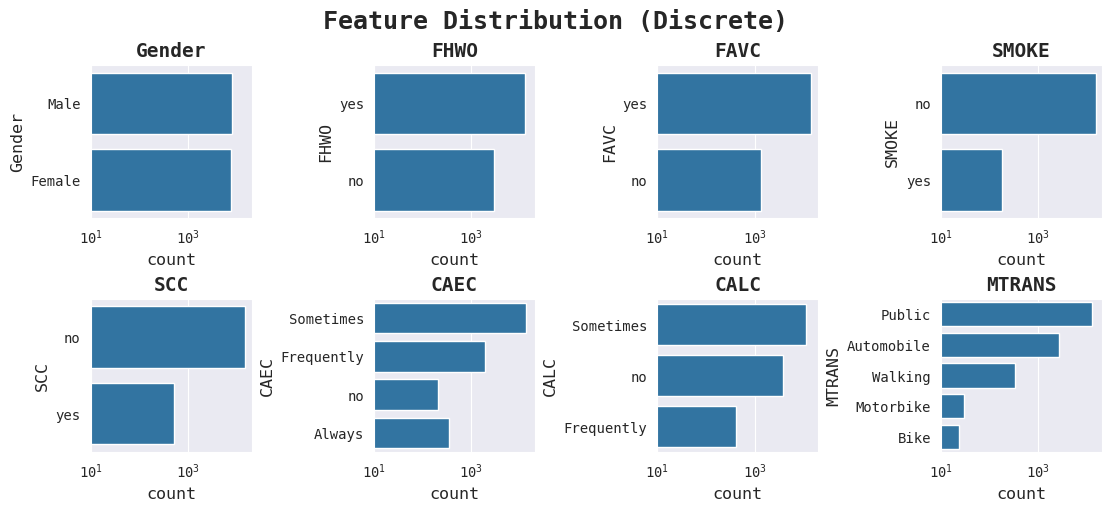

In [22]:
fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), categorical_features):
    sns.countplot(ds_source[col], ax=ax)
    annotate_plot(ax, col), ax.set_xscale('log'), ax.set_xlim(10, 20000)
    if col == 'MTRANS': ax.set_yticks(range(5), ['Public', 'Automobile', 'Walking', 'Motorbike', 'Bike'], **font_ticks)
conclude_plot("Feature Distribution (Discrete)", constrained=True)

**Observation**:
* Gender is very well distributed
* Family History With Overweight and High Caloric Food Consumption Freq has small skewedness
* Smoke and Calories Consumption Monitoring has moderate skewedness
* Consumption of Food Between Meals, Consumption of alcohol, and Means of Transportation Used are extremely skewedness

**Inference**:
* TODO

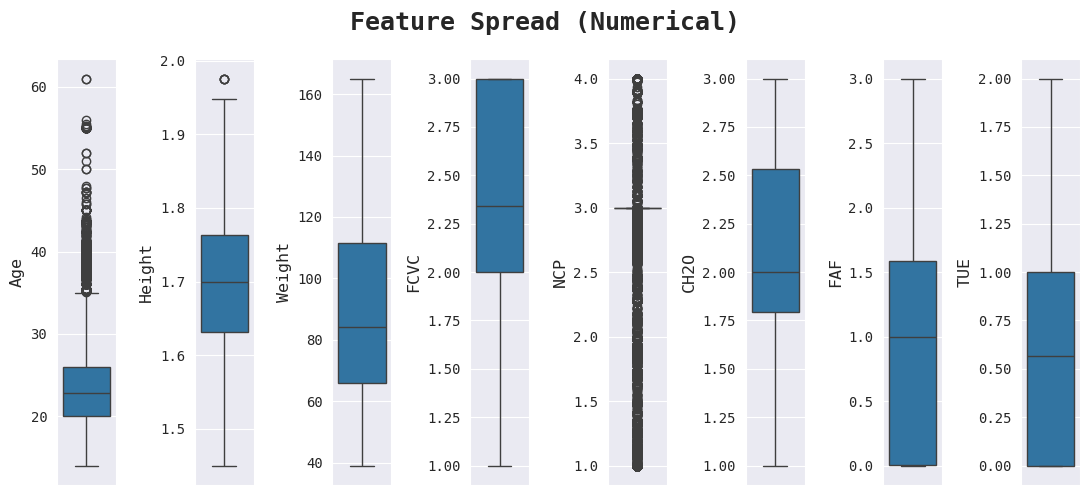

In [23]:
fig, axs = plt.subplots(1, 8, figsize=(max_fig_width, 5))
for ax, column in zip(flatten(axs), numerical_features):
    sns.boxplot(y=column, data=ds_source, ax=ax)
conclude_plot("Feature Spread (Numerical)")

**Observation**:
* TODO

**Inference**:
* TODO

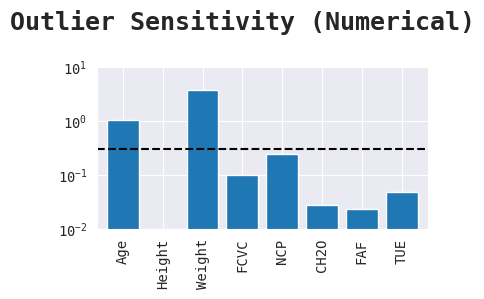

In [24]:
plt.figure(figsize=sml_fig)
_ds_num = ds_source[numerical_features]
(_ds_num.mean() - _ds_num.median()).abs().plot(kind='bar', width=0.8)
plt.yscale('log'), plt.ylim(0.01, 10)
plt.axhline(0.3, color='black', linestyle='--')
conclude_plot("Outlier Sensitivity (Numerical)")

**Observation**:
* TODO

**Inference**:
* TODO

## Data Processing

### Experimenting on AGE Feature

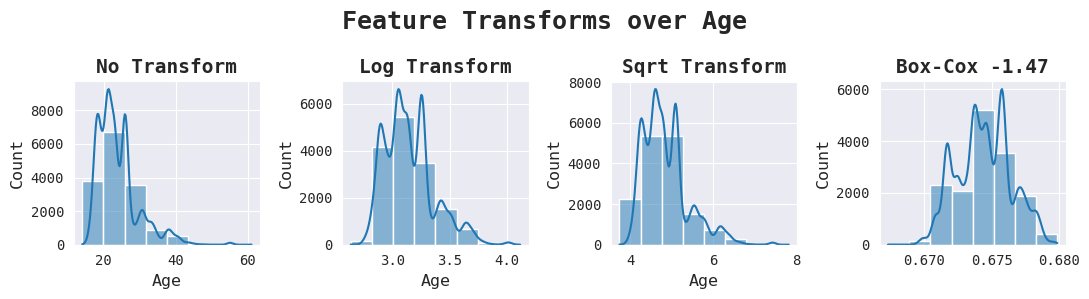

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_bclam, _bcage = pop_box_cox_transform(ds_source['Age'])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['Age']],
        ['Log Transform', pop_log_transform(ds_source['Age'])[1]],
        ['Sqrt Transform', pop_root_transform(ds_source['Age'])[1]],
        ['Box-Cox %.2f' % _bclam, _bcage],
)):
    sns.histplot(data, kde=True, bins=8, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Feature Transforms over Age")

### Experimenting on NCP Feature

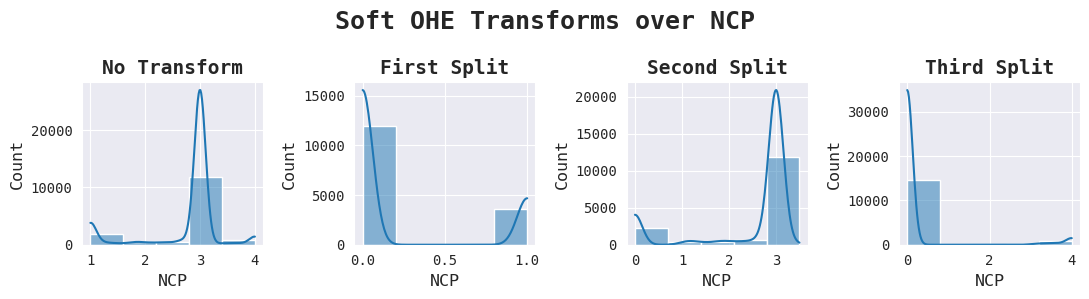

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_, _scd_ncp = pop_soft_ohe(ds_source['NCP'], [1, 3, 3.5])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['NCP']],
        ['First Split', _scd_ncp[0]],
        ['Second Split', _scd_ncp[1]],
        ['Third Split', _scd_ncp[2]],
)):
    sns.histplot(data, kde=True, bins=5, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Soft OHE Transforms over NCP")

## Data Pipelining

#### For Regression Based Models

In [37]:
regression_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory']),
        (pop_binarize, binary_features),
        (pop_one_hot_encode, nary_features),
    ],
    [  # Permutable ones
        [  # No Chill
        ],
        [  # Simple Life
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, numerical_features),
        ],
        [  # Encoded Q-Conts
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, gaussian_features),
            (pop_round, partial_features),
            (pop_one_hot_encode, partial_features),
        ],
        [  # Soft Hot Encode
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, gaussian_features),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), ['FCVC']),
            (prepare_pop(pop_soft_ohe, [1, 3, 4]), ['NCP']),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), ['CH2O']),
            (prepare_pop(pop_soft_ohe, [0, 1, 2, 3]), ['FAF']),
            (prepare_pop(pop_soft_ohe, [0, 1, 2]), ['TUE']),
        ],
    ],
]
regression_pipeline_derived = regression_pipeline.copy()
regression_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory']),
    (pop_derived_features, [all_features]),
    (pop_binarize, binary_features),
    (pop_one_hot_encode, nary_features),
    (pop_standardize, numerical_derived_features),
    (pop_binarize, binary_derived_features),
]
# next(apply_pipeline(ds_source.head(10), regression_pipeline_derived, False))[1]

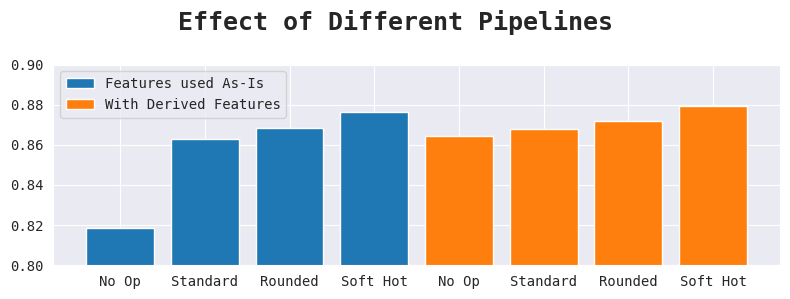

In [38]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'])[1].to_numpy()
_scores = []

for pipeline in [regression_pipeline, regression_pipeline_derived]:
    for args, ds_sample in apply_pipeline(ds_source, pipeline):
        model = skl.linear_model.LogisticRegression(max_iter=1000)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)
            model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plt.figure(figsize=wid_fig)
plt.bar(range(4), _scores[:4], label='Features used As-Is')
plt.bar(range(4, 8), _scores[4:], label='With Derived Features')
plt.xticks(range(len(_scores)), ['No Op', 'Standard', 'Rounded', 'Soft Hot'] * 2)
plt.ylim(min(0.8, np.min(_scores)), max(0.9, np.max(_scores)))
plt.legend()
conclude_plot("Effect of Different Pipelines")

#### For Tree Based Models

In [32]:
tree_pipeline = [
    [  # Compulsory ones
        (pop_binarize, binary_features),
        (pop_drop_column, ['id', 'WeightCategory']),
    ],
    [  # Permutable ones
        [  # Ordinal Encoded
            (pop_ordinal_encode, nary_features),
        ],
        [  # One Hot Encoded
            (pop_one_hot_encode, nary_features),
        ],
    ],
]
tree_pipeline_derived = tree_pipeline.copy()
tree_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory']),
    (pop_derived_features, [all_features]),
    (pop_binarize, binary_features),
    (pop_standardize, numerical_derived_features),
    (pop_binarize, binary_derived_features),
]

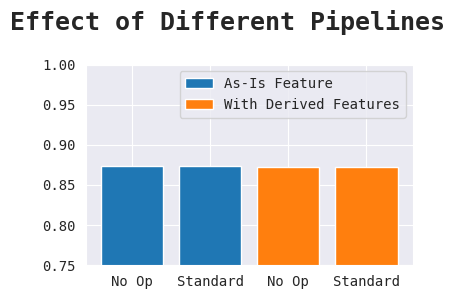

In [35]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'])[1].to_numpy()
_scores = []

for pipeline in [tree_pipeline, tree_pipeline_derived]:
    for args, ds_sample in apply_pipeline(ds_source, pipeline):
        model = skl.tree.DecisionTreeClassifier(max_depth=7)
        model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plt.figure(figsize=sml_fig)
plt.bar(range(2), _scores[:2], label='Features used As-Is')
plt.bar(range(2, 4), _scores[2:], label='With Derived Features')
plt.xticks(range(len(_scores)), ['No Op', 'Standard'] * 2)
plt.ylim(min(0.75, np.min(_scores)), max(1.0, np.max(_scores)))
plt.legend()
conclude_plot("Effect of Different Pipelines")

In [24]:
# TODO: Implement this pop
ds_source['MTRANS'] = ds_source['MTRANS'].map(lambda x: x if x in ('Public_Transportation', 'Automobile') else 'Others')
ds_test['MTRANS'] = ds_test['MTRANS'].map(lambda x: x if x in ('Public_Transportation', 'Automobile') else 'Others')

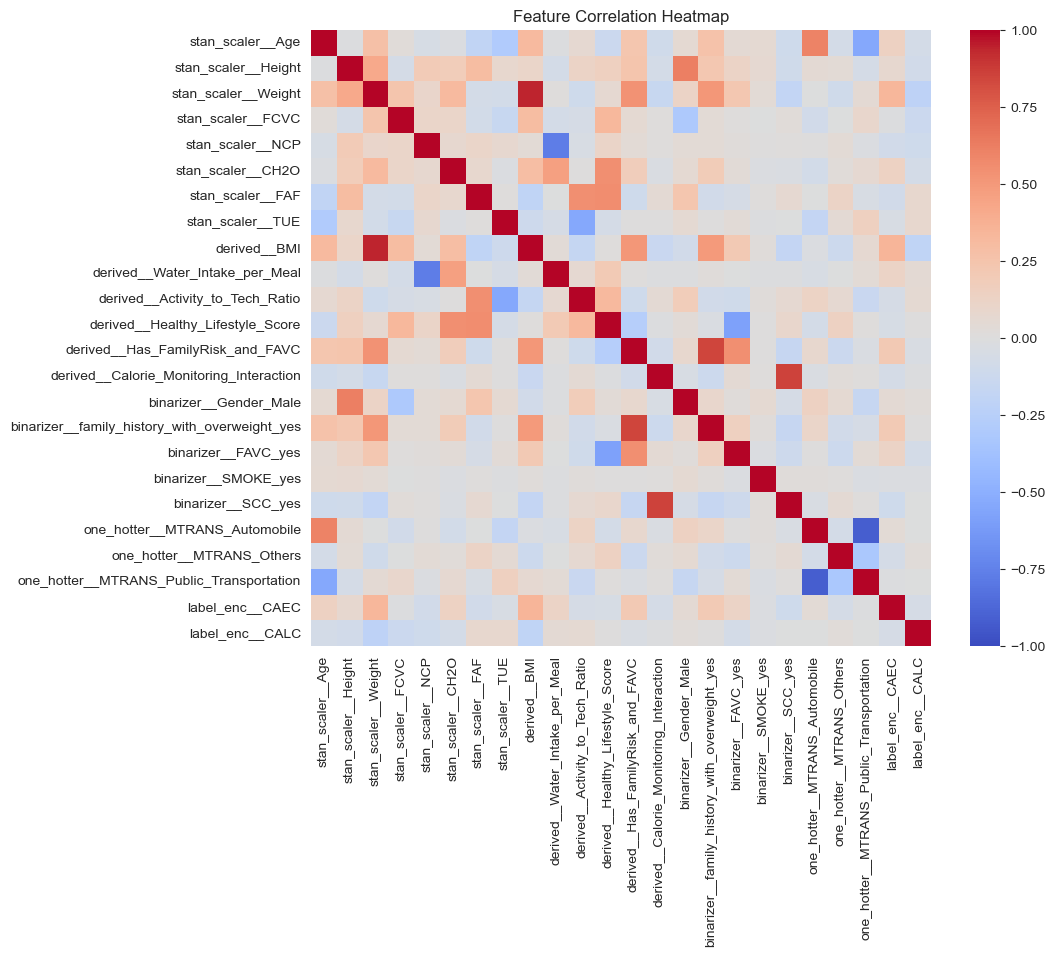

In [70]:
pop_binarizer2 = ('binarizer', skl.preprocessing.OneHotEncoder(drop='if_binary', sparse_output=False), binary_features)
pop_one_hotter2 = ('one_hotter', skl.preprocessing.OneHotEncoder(sparse_output=False), ['MTRANS'])
pop_everything3 = skl.compose.ColumnTransformer(
    [pop_stan_scaler, pop_derived_features, pop_binarizer2, pop_one_hotter2, pop_label_enc])
pop_everything3.set_output(transform='pandas')

ds_source_transf = pop_everything3.fit_transform(ds_source)
corr = ds_source_transf.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [71]:
ds_source_transf.columns.size

24

TVT S

Mdel

In [33]:

pop_everything = skl.compose.ColumnTransformer(
    [pop_stan_scaler, pop_derived_features, pop_binarizer, pop_one_hotter, pop_label_enc])
data_x = pop_everything.fit_transform(ds_source)
data_test = pop_everything.transform(ds_test)
data_y = ds_labels.map(label_encoder).to_numpy()


In [34]:
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(data_x, data_y, test_size=0.2, random_state=42)

In [35]:
ds_source.shape

(15533, 16)

In [36]:
data_x.shape

(15533, 24)

In [37]:
data_test.shape

(5225, 24)

In [38]:
ds_test.shape

(5225, 16)

In [43]:
def save_submission(key, model):
    ds_res = pd.DataFrame()
    ds_res['id'] = ds_test_ids
    ds_res['WeightCategory'] = model.predict(data_test)
    ds_res['WeightCategory'] = ds_res['WeightCategory'].map(label_decoder)
    ds_res.to_csv(f'submission_{key}.csv', index=False)

In [40]:
data_test.shape

(5225, 24)

In [41]:
model = skl.linear_model.LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)
print('Train', model.score(x_train, y_train))
print('Test ', model.score(x_test, y_test))
chime.info()

Train 0.8641558023499115
Test  0.8619246861924686


In [44]:
save_submission('lr', model)

In [33]:
# history = {}
# for penalty, c, solver in itertools.product(
#         [None, 'l1', 'l2', 'elasticnet'],
#         [1.0],
#         ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# ):
#     key = f'penalty={penalty},c={c},solver={solver}'
#     print("Training", key)
#     try:
#         model = skl.linear_model.LogisticRegression(
#             penalty=penalty, C=c, solver=solver,
#             max_iter=1000, n_jobs=-1)
#         model.fit(data_x, data_y)
#         history[key] = {'model': model, 'score': model.score(data_x, data_y)}
#     except Exception as e:
#         print("Not possible", e)

In [34]:
# history = {}
# for penalty, c, solver in itertools.product(
#         [None, 'l1', 'l2', 'elasticnet'],
#         [1.0],
#         ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# ):
#     key = f'penalty={penalty},c={c},solver={solver}'
#     print("Training", key)
#     try:
#         model = skl.linear_model.LogisticRegression(
#             penalty=penalty, C=c, solver=solver,
#             max_iter=1000, n_jobs=-1)
#         model.fit(data_x, data_y)
#         history[key] = {'model': model, 'score': model.score(data_x, data_y)}
#     except Exception as e:
#         print("Not possible", e)

In [35]:
model = skl.tree.DecisionTreeClassifier(max_depth=15)
model.fit(x_train, y_train)
model.score(x_train, y_train)
model.score(x_test, y_test)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [56]:
seed = np.random.randint(0, 100000)
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(data_x, data_y, test_size=0.2,
                                                                        random_state=seed)
print('seed', seed)
model = skl.tree.DecisionTreeClassifier(max_depth=10)
model.fit(x_train, y_train)
print('Train', model.score(x_train, y_train))
print('Test ', model.score(x_test, y_test))
save_submission('DT', model)

seed 16462
Train 0.9122002253339772
Test  0.8738332796910203


In [222]:
model = skl.ensemble.AdaBoostClassifier()
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.7741831643328505
0.7698744769874477


In [232]:
model = skl.ensemble.AdaBoostClassifier(n_estimators=100, learning_rate=0.7)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

0.7995332367616288
0.8023817186997103


In [233]:
model = skl.ensemble.RandomForestClassifier(n_estimators=100)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))
print(model.score(x_test, y_test))

1.0
0.8934663662697135


In [45]:
model = skl.ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(x_train, y_train)
print('Train', model.score(x_train, y_train))
print('Test ', model.score(x_test, y_test))
save_submission('RF_100estim_10depth', model)

Train 0.9336069531627234
Test  0.8950756356614097


In [56]:
model = skl.ensemble.RandomForestClassifier(n_jobs=-1, random_state=16462)
gs_model = skl.model_selection.GridSearchCV(model, {
    'n_estimators': range(50, 150, 10),
    'max_depth': range(5, 15),
})
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_RF', gs_model)
chime.success()

In [77]:
model = skl.ensemble.RandomForestClassifier(n_jobs=-1, random_state=16462)
gs_model = skl.model_selection.GridSearchCV(model, {
    'n_estimators': range(60, 100, 1),
    'max_depth': range(10, 15),
})
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_RF', gs_model)
chime.success()

Params {'max_depth': 12, 'n_estimators': 80}
Train  0.956623209399646
Test   0.8966849050531059


In [75]:
# model = skl.ensemble.RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=16462)
# rfecv = skl.feature_selection.RFECV(estimator=model, step=1, cv=skl.model_selection.StratifiedKFold(10))
# pipeline = skl.pipeline.Pipeline([('feature_selection', rfecv), ('classification', model)])
# gs_model = skl.model_selection.GridSearchCV(pipeline, {
#     'classification__n_estimators': range(60, 100, 2),
#     'classification__max_depth': range(10, 15),
# }, n_jobs=-1, verbose=2)
# gs_model.fit(x_train, y_train)
# print('Params', gs_model.best_params_)
# print('Train ', gs_model.score(x_train, y_train))
# print('Test  ', gs_model.score(x_test, y_test))
# save_submission('GS_FE_RF', gs_model)
# chime.success()

KeyboardInterrupt: 

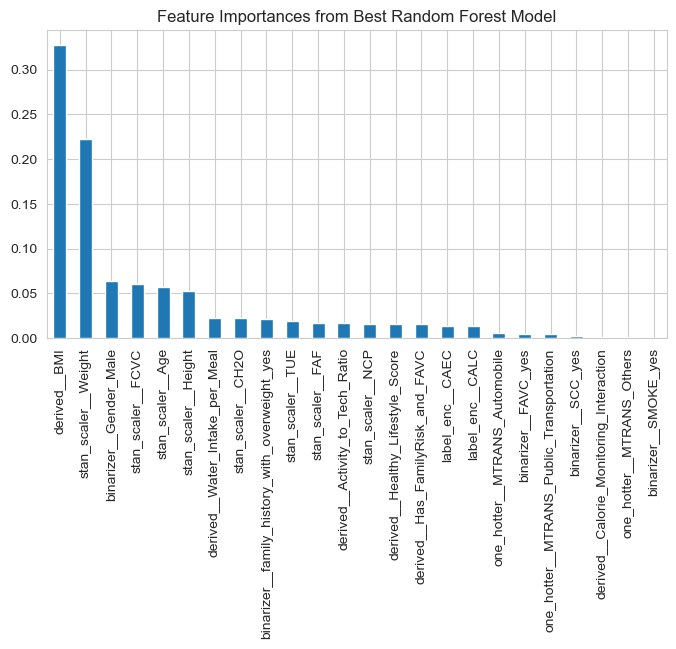

In [72]:
pd.Series(gs_model.best_estimator_.feature_importances_, index=ds_source_transf.columns).sort_values(
    ascending=False).plot(kind='bar', figsize=(8, 4))
plt.title("Feature Importances from Best Random Forest Model")
plt.show()

In [ ]:
gs_model.best_params_

In [80]:
seed = np.random.randint(0, 10000)
print('seed', seed)
dt_model = skl.tree.DecisionTreeClassifier(random_state=seed)
ada_model = skl.ensemble.AdaBoostClassifier(estimator=dt_model, random_state=seed)
gs_model = skl.model_selection.GridSearchCV(estimator=ada_model, param_grid={
    'n_estimators': range(245, 255),
    'estimator__max_depth': [9, 10, 11]
}, scoring='accuracy', cv=5, n_jobs=14, verbose=2)
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_ADA', gs_model)
chime.success()

seed 7204
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Params {'estimator__max_depth': 10, 'learning_rate': 1, 'n_estimators': 250}
Train  1.0
Test   0.8921789507563566


In [88]:
len(ds_labels.unique())

7

In [94]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob'
    num_class=len(ds_labels.unique()),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=seed
)
param_grid = {
    'n_estimators': [204],
    'max_depth': [4],
    'learning_rate': [0.1],
    'subsample': [0.64, 0.65, .66],
    'colsample_bytree': [.75, .76]
}
gs_model = skl.model_selection.GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                                            scoring='accuracy', cv=3, n_jobs=14, verbose=3)
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_XGB', gs_model)
chime.success()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Params {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 204, 'subsample': 0.65}
Train  0.9490584258812168
Test   0.8979723205664628


In [96]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob'
    num_class=len(ds_labels.unique()),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=seed
)
param_grid = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [0.1],
    'subsample': [.8],
    'colsample_bytree': [.8]
}
gs_model = skl.model_selection.GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy',
                                            cv=3, n_jobs=14, verbose=3)
gs_model.fit(x_train, y_train)
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('GS_XGB', gs_model)
chime.success()

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Params {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Train  0.9278931273136971
Test   0.895397489539749


In [36]:
len(ds_test)

5225

In [134]:
seed = np.random.randint(0, 10000)
print('seed', seed)
x_train, x_test, y_train, y_test = skl.model_selection.train_test_split(data_x, data_y, test_size=0.2,
                                                                        random_state=seed)
dists = []
for i in range(data_test.shape[0]):
    # dists.append(((data_test[i] - x_train) ** 2).sum(axis=1).argmin())
    indices = ((data_test[i] - x_train) ** 2).sum(axis=1).argsort()[:2]
    dists.append(indices[0])
    dists.append(indices[1])
print((((data_test - x_train[dists[::2]]) ** 2).sum(axis=1) ** 0.5).mean())

seed 797
1.1538748510714392


In [137]:
seed = 1745
print('seed', seed)
dt_model = skl.tree.DecisionTreeClassifier(random_state=seed, max_depth=10)
ada_model = skl.ensemble.AdaBoostClassifier(estimator=dt_model, random_state=seed, n_estimators=250)
ada_model.fit(x_train[dists], y_train[dists])
print('Params', gs_model.best_params_)
print('Train ', gs_model.score(x_train, y_train))
print('Test  ', gs_model.score(x_test, y_test))
save_submission('CH_ADA', gs_model)
chime.success()

seed 1745
Params {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Train  0.9197650088524062
Test   0.9279047312520116


In [136]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # or 'multi:softprob'
    num_class=len(ds_labels.unique()),
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=seed,
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)
xgb_model.fit(x_train[dists], y_train[dists])
print('Train ', xgb_model.score(x_train, y_train))
print('Test  ', xgb_model.score(x_test, y_test))
save_submission('CH_XGB', xgb_model)
chime.success()

Train  0.9125221310156124
Test   0.9079497907949791
